In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [4]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [5]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [6]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [7]:
# Save references to each table
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station


In [8]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Precipitation Analysis

In [10]:
# Find the most recent date in the data set.
# Find the most recent date in the data set
most_recent_date = session.query(func.max(Measurement.date)).scalar()

print(f"The most recent date in the data set is: {most_recent_date}")


The most recent date in the data set is: 2017-08-23


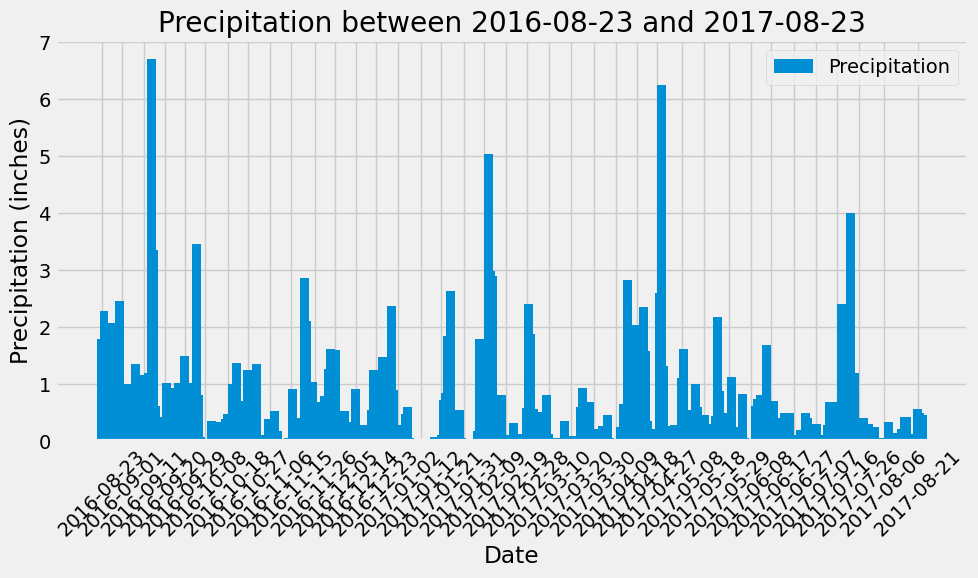

In [20]:
# Calculate the date one year before the most recent date
one_year_ago = most_recent_date - dt.timedelta(days=365)

# Define the start and end dates
start_date = '2016-08-23'
end_date = '2017-08-23'

# Perform a query to retrieve the data and precipitation scores
precipitation_data = session.query(Measurement.date, Measurement.prcp).\
    filter(Measurement.date >= start_date, Measurement.date <= end_date).all()

# Save the query results as a Pandas DataFrame
precipitation_df = pd.DataFrame(precipitation_data, columns=['Date', 'Precipitation'])

# Sort the dataframe by date
precipitation_df = precipitation_df.sort_values(by='Date')

# Use Pandas Plotting with Matplotlib to plot the data
# Use Pandas Plotting with Matplotlib to plot the data
plt.figure(figsize=(10, 6))
plt.bar(precipitation_df['Date'], precipitation_df['Precipitation'], width=4, label='Precipitation')
plt.xlabel('Date')
plt.ylabel('Precipitation (inches)')
plt.title('Precipitation between 2016-08-23 and 2017-08-23')

# Set x-axis tick labels every 60 days
date_labels = precipitation_df['Date'][::60]
plt.xticks(date_labels, rotation=45)

plt.legend()
plt.tight_layout()
plt.show()

In [21]:
# Use Pandas to calculate the summary statistics for the precipitation data
summary_stats = precipitation_df['Precipitation'].describe()
print(summary_stats)

count    2021.000000
mean        0.177279
std         0.461190
min         0.000000
25%         0.000000
50%         0.020000
75%         0.130000
max         6.700000
Name: Precipitation, dtype: float64


# Exploratory Station Analysis

In [24]:
# Perform a query to calculate the total number of stations
total_stations = session.query(func.count(Station.station)).scalar()

print(f"The total number of stations in the dataset is: {total_stations}")



The total number of stations in the dataset is: 9


In [35]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
# List the stations and their counts in descending order.
# Perform a query to find the most active stations and their counts
most_active_stations = session.query(Measurement.station, func.count(Measurement.station)).\
    group_by(Measurement.station).\
    order_by(func.count(Measurement.station).desc()).all()

print("Most Active Stations:")
for station, count in most_active_stations:
    print(f"Station: {station}, Count: {count}")



Most Active Stations:
Station: USC00519281, Count: 2772
Station: USC00519397, Count: 2724
Station: USC00513117, Count: 2709
Station: USC00519523, Count: 2669
Station: USC00516128, Count: 2612
Station: USC00514830, Count: 2202
Station: USC00511918, Count: 1979
Station: USC00517948, Count: 1372
Station: USC00518838, Count: 511


In [36]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
# Query to find the most active station
most_active_station = session.query(Measurement.station, func.count(Measurement.station)).\
    group_by(Measurement.station).\
    order_by(func.count(Measurement.station).desc()).\
    first()

# Extract the station ID of the most active station
most_active_station_id = most_active_station[0]

# Query to calculate the lowest, highest, and average temperature for the most active station
temperature_stats = session.query(func.min(Measurement.tobs), func.max(Measurement.tobs), func.avg(Measurement.tobs)).\
    filter(Measurement.station == most_active_station_id).\
    all()

# Print the results
print(f"Temperature statistics for the most active station (Station ID: {most_active_station_id}):")
print(f"Lowest Temperature: {temperature_stats[0][0]}")
print(f"Highest Temperature: {temperature_stats[0][1]}")
print(f"Average Temperature: {temperature_stats[0][2]}")


Temperature statistics for the most active station (Station ID: USC00519281):
Lowest Temperature: 54.0
Highest Temperature: 85.0
Average Temperature: 71.66378066378067


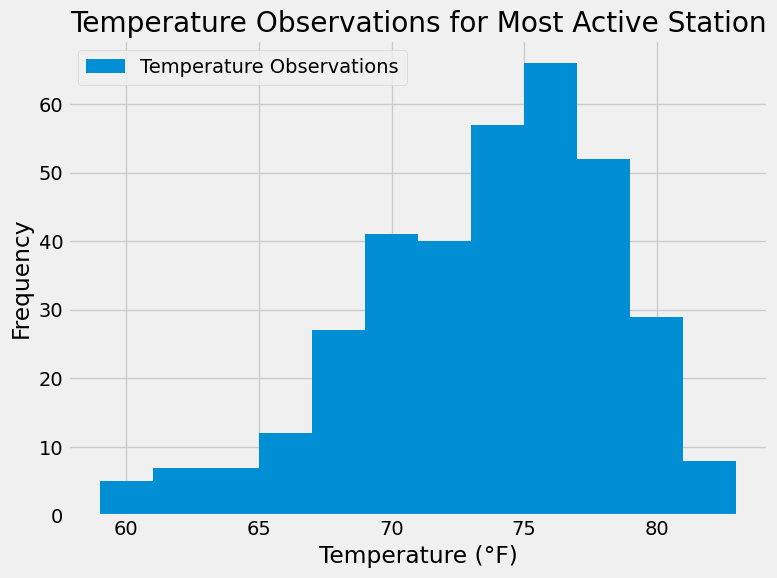

Lowest Temperature: 54.0°F
Highest Temperature: 85.0°F
Average Temperature: 71.66°F


In [45]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
temperature_data = session.query(Measurement.tobs).\
filter(Measurement.station == most_active_station_id, Measurement.date >= one_year_ago).\
    all()

# Convert the query results to a list
temperature_list = [temp[0] for temp in temperature_data]

# Plot the results as a histogram
plt.figure(figsize=(8, 6))
plt.hist(temperature_list, bins=12, label='Temperature Observations')
plt.xlabel('Temperature (°F)')
plt.ylabel('Frequency')
plt.title('Temperature Observations for Most Active Station')
plt.legend()
plt.tight_layout()
plt.show()

# Extract the temperature statistics from the query results
(min_temp, max_temp, avg_temp) = temperature_stats[0]

print(f"Lowest Temperature: {min_temp}°F")
print(f"Highest Temperature: {max_temp}°F")
print(f"Average Temperature: {avg_temp:.2f}°F")


# Close Session

In [46]:
# Close Session
session.close()